In [205]:
import numpy as np
import importlib
import quasibi
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt

importlib.reload(quasibi);

In [158]:
ds_weekly = xa.load_dataset("../data/data_downsampled_binned.nc")

LAT, LON = np.meshgrid(ds_weekly.latitude, ds_weekly.longitude, indexing="ij")
LAT, LON = LAT.flatten(), LON.flatten()

# Pearson Correlation Calculation

In [298]:
# load all the time series
ys = np.load("../data/data_downsampled_binned.npy")

In [23]:
%%time

# calculate pairwise pearson correlation coefficients
# pearson = pairwise_distances(ys, metric=quasibi.pearson)

CPU times: total: 8min 5s
Wall time: 8min 6s


In [24]:
# save the pearson matrix
quasibi.save_symmat(pearson, "../output/pearson_correlation_matrix")

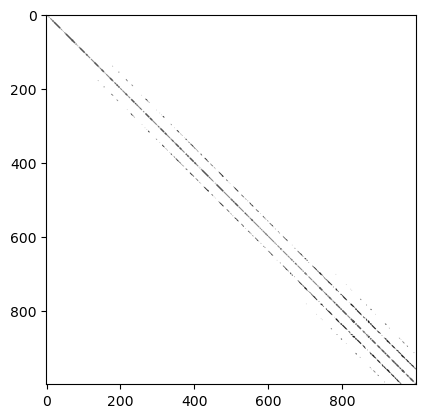

In [26]:
pearson_abs = np.abs(pearson)
plt.imshow(pearson_abs > np.quantile(pearson_abs, 0.995), cmap="binary")

# Network Metrics

In [288]:
def degree_centrality(nx):
    return np.fromiter(networkx.degree_centrality(nx).values(), dtype="float32")

def awc(nx, LAT):
    AWC = np.sum(networkx.to_numpy_array(nx)*np.cos(np.deg2rad(LAT)), axis=0)/np.sum(np.cos(np.deg2rad(LAT)))
    return AWC.reshape((25, 40))
    
def betweenness(nx):
    return np.fromiter(networkx.betweenness_centrality(nx).values(), dtype="float32")

def closeness(nx):
    return np.fromiter(networkx.closeness_centrality(nx).values(), dtype="float32")

def clustering_coefficient(nx):
    return np.fromiter(networkx.clustering(nx).values(), dtype="float32")

def network_metric(A, func, surrogates=None, **kwargs):
    
    # calculate the metric for the adjacency matrix
    m = func(networkx.from_numpy_matrix(A), **kwargs).reshape((25, 40))
    
    if surrogates is None:
        return m
    else:
        M = np.mean([func(networkx.from_numpy_matrix(surrogate), **kwargs).reshape((25, 40)) for surrogate in surrogates], axis=0)
        return m, m - M, M

In [238]:
#network_metric(pearson, degree_centrality, S)

In [54]:
import networkx
import xarray as xa
import cartopy.crs as ccrs

In [35]:
pearson = quasibi.load_symmat("../output/pearson_correlation_matrix.npy")
pearson = np.abs(pearson) > np.quantile(np.abs(pearson), 0.995)

In [36]:
pearson_network = networkx.from_numpy_matrix(pearson)

In [289]:
# degree centrality
cen, cenC, cenB = network_metric(pearson, degree_centrality, S)

In [291]:
# area weighted connectivity
awc, awcC, awcB = network_metric(pearson, awc, S, LAT=LAT)

In [296]:
%%time
# betweenness 
bet = network_metric(pearson, betweenness)

CPU times: total: 1.72 s
Wall time: 1.73 s


In [294]:
# closeness
#clo, cloC, cloB = network_metric(pearson, closeness, S)

In [295]:
# clustering coefficient
#clc, clcC, clcB = network_metric(pearson, clustering_coefficient, S)

# Surrogate Networks

In [203]:
D = quasibi.load_symmat("../output/distance.npy")

2023-03-23 20:31:40.773 | INFO     | quasibi:create_surrogate_adjacency_matrix:272 - Preparing plots


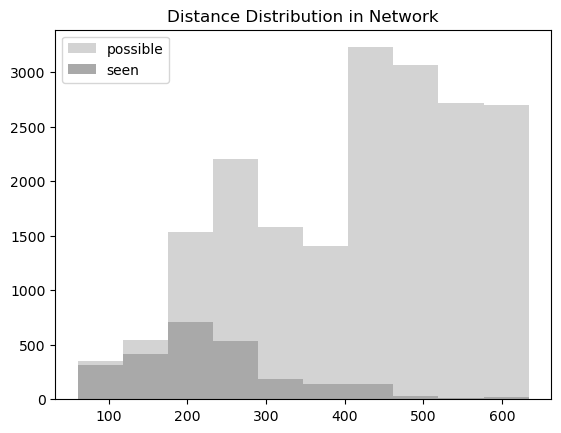

In [283]:
S = quasibi.create_surrogate_adjacency_matrix(pearson, D, plot=True, n_surrogates=500)

# Plots

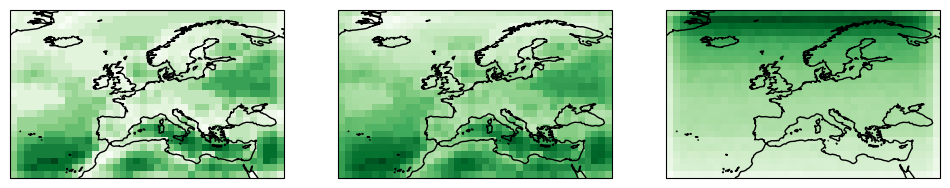

In [286]:
fig, axs = plt.subplots(1, 3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(12, 4))

for ax, metric in zip(axs, [cen, cenC, cenB]):
    ax.coastlines()
    cmap = ax.imshow(metric, extent=[np.min(LON), np.max(LON), np.min(LAT), np.max(LAT)], cmap="Greens")

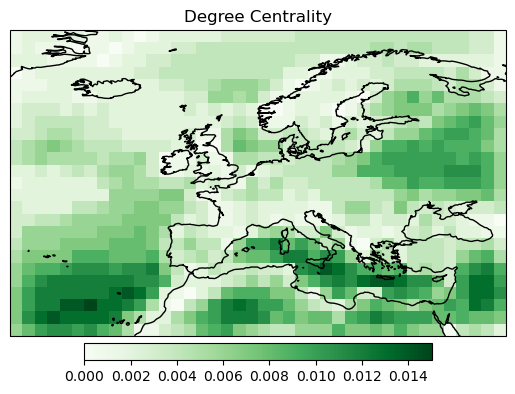

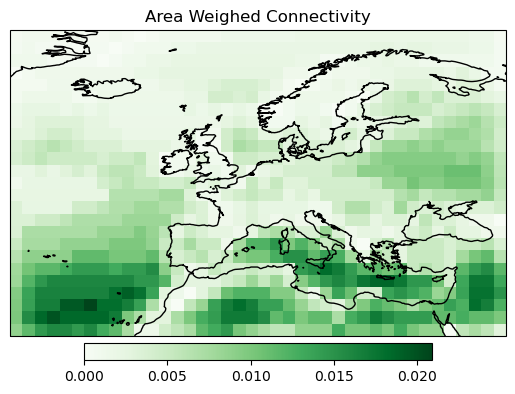

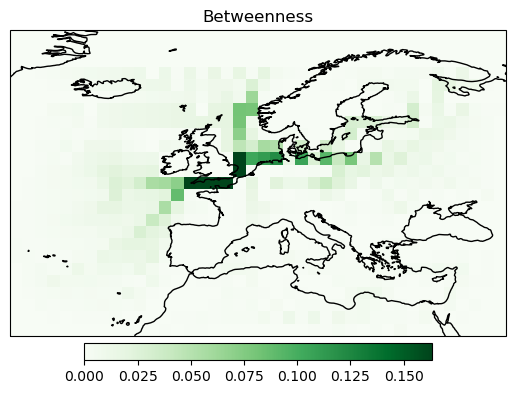

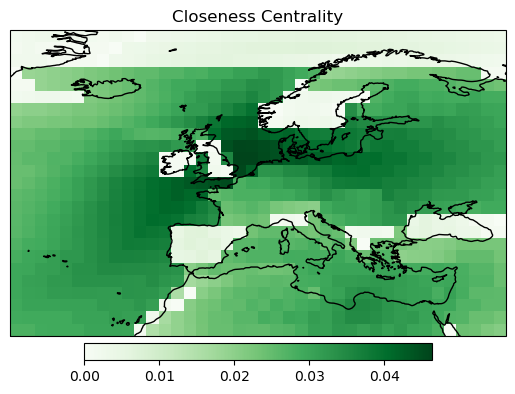

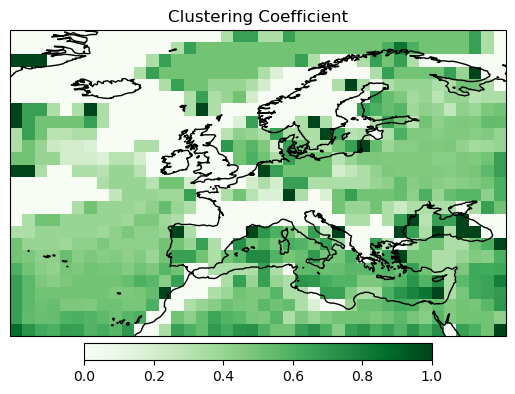

In [269]:
for metric, name in zip([cen, awc, bet, clo, clc] , [cen, awc, bet, clo, clc]["Degree Centrality", "Area Weighed Connectivity", "Betweenness", "Closeness Centrality", "Clustering Coefficient"]):
    ax = plt.axes(projection=ccrs.PlateCarree())
    cmap = ax.imshow(metric, extent=[np.min(LON), np.max(LON), np.min(LAT), np.max(LAT)], cmap="Greens")
    ax.coastlines()
    plt.colorbar(cmap, location="bottom", shrink=0.7, pad=0.02)
    plt.title(name)
    plt.show()